In [3]:
from scipy.special import erfc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import diags
%matplotlib inline

Text(0, 0.5, 'Call price')

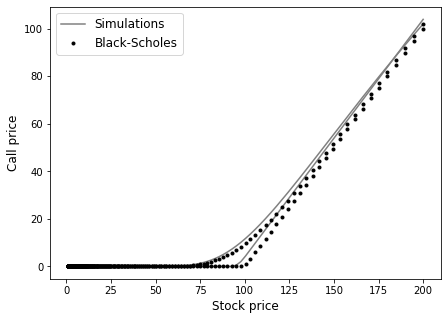

In [4]:
x_max = np.log(200) # ????
t_max = 1 # total time in yr
dt = 0.005 # grid size for time 
dx = dt*x_max/t_max # grid size for x
sigma = 0.3
r = 0.04
K = 100

# function to calculate call profiles based on a 
# finite difference approximation to the 1D 
# equation and the FTCS scheme:
def call_FTCS(dt,dx,t_max,x_max,r,sigma):
    # diffusion number (has to be less than 0.5 for the 
    # solution to be stable):
    b1 = (r-(sigma**2)/2)*(dt/(2*dx)) + ((sigma**2)/2)*(dt/(dx**2))
    b0 = 1 - (sigma**2)*(dt/(dx**2)) - r*dt
    b_1 = ((sigma**2)/2)*(dt/(dx**2)) - (r-(sigma**2)/2)*(dt/(2*dx))
    x = np.arange(0,x_max+dx,dx) 
    t = np.arange(0,t_max+dt,dt)
    S = np.exp(x)
    
    T = len(t)
    X = len(x)
    V = np.zeros([T,X])
    # boundary conditions
    V[:,0] = 0
    V[:,X-1] = np.exp(x_max) - K*np.exp(-r*(t_max-t))
    V[0,:] = np.max(np.vstack((np.zeros(len(x)),np.exp(x)-K*np.exp(-r*t_max))),axis=0)
    for n in range(0,T-1): # time
        for j in range(1,X-1): # space
            V[n+1,j] = b1*V[n,j+1] + b0*V[n,j] + b_1*V[n,j-1]
    
    return S,V
# note that this can be written without the for-loop 
# in space, but it is easier to read it this way

def black_scholes(S, K, T, r, sigma, call_put='call'):   
    """Return black scholes price of an option"""
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if call_put == 'call':
        optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    elif call_put == 'put':
        optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
    return optionprice

S,V = call_FTCS(dt,dx,t_max,x_max,r,sigma)
# plotting:
plt.figure(figsize=(7,5))
plot_times = np.arange(dt,t_max,100*dt)
for t in plot_times:
    plt.plot(S,V[int(t/dt),:],color='Gray', label='Simulations')
    V_bs = black_scholes(S, K, t, r, sigma)
    plt.plot(S,V_bs,'ok',label='Black-Scholes',
            markersize=3)
    if t==dt:
        plt.legend(fontsize=12)
plt.xlabel('Stock price',fontsize=12)
plt.ylabel('Call price',fontsize=12)


<ipython-input-5-12a740d2a2c4>:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.axis([0,np.exp(x_max),0,V[0]])


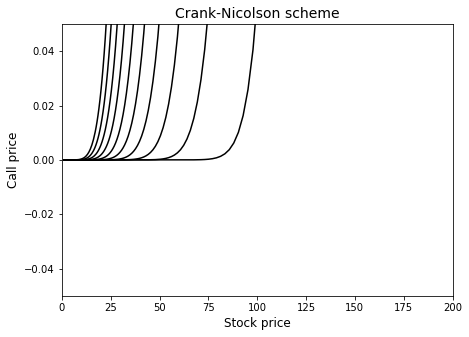

In [5]:
a1 = -(r-(sigma**2)/2)*(dt/(4*dx)) - ((sigma**2)/4)*(dt/(dx**2))
a0 = 1 + ((sigma**2)/2)*(dt/(dx**2)) + r*dt
a_1 = (r-(sigma**2)/2)*(dt/(4*dx)) - ((sigma**2)/4)*(dt/(dx**2))
b1 = (r-(sigma**2)/2)*(dt/(4*dx)) + ((sigma**2)/4)*(dt/(dx**2))
b0 = 1 - ((sigma**2)/2)*(dt/(dx**2))
b_1 = ((sigma**2)/4)*(dt/(dx**2)) - (r-(sigma**2)/2)*(dt/(4*dx))

def call_Crank_Nicolson(dx,nx,dt,nt,V,ntout):
    Vout = [] # list for storing V arrays at certain time steps
    V0 = V[0] # boundary condition on left side
    V1 = V[-1] # boundary condition on right side
    # create coefficient matrix:
    A = diags([a_1, a0, a1], [-1, 0, 1], 
          shape=(nx-2, nx-2)).toarray() 
    B1 = diags([b_1, b0, b1],[-1, 0, 1], shape=(nx-2, nx-2)).toarray()
    for n in range(1,nt): # time is going from second time step to last
        Vn = V
        B = np.dot(Vn[1:-1],B1) 
        B[0] = B[0] - a_1*V0
        B[-1] = B[-1] - a_1*V1
        V[1:-1] = np.linalg.solve(A,B)
        if n % int(nt/float(ntout)) == 0 or n==nt-1:
            Vout.append(V.copy()) # numpy arrays are mutable, 
            #so we need to write out a copy of V, not V itself
    return Vout
 
x_max = np.log(200) # ????
t_max = 1 # total time in yr
dt = 0.005 # grid size for time 
dx = dt*x_max/t_max # grid size for x
sigma = 0.3
r = 0.04
K = 100


x = np.arange(0,x_max+dx,dx) 
S = np.exp(x)
nx = len(x)
nt = 1000
plt.figure(figsize=(7,5))
V = np.zeros((nx,)) # initial condition
V[0] = 0
V[-1] = np.exp(x_max) - K*np.exp(-r*(t_max-t))
Vout = call_Crank_Nicolson(dx,nx,dt,nt,V,10)
 
for V in Vout:
    plt.plot(S,V,'k')
plt.xlabel('Stock price',fontsize=12)
plt.ylabel('Call price',fontsize=12)
plt.axis([0,np.exp(x_max),0,V[0]])
plt.title('Crank-Nicolson scheme',fontsize=14);